In [1]:
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [2]:
df_raw = pl.read_parquet("./data/dengue.parquet")
df_validation = pl.read_parquet('./data/dengue_val.parquet')


In [3]:
df_raw = df_raw.with_row_index("row_id")
train_mortes = df_raw.filter(pl.col("TARGET_OBITO") == 1)
n_mortos_train = train_mortes.height

# Completar até 250.000 com vivos
n_vivos_necessarios = 500_000 - n_mortos_train
train_vivos = df_raw.filter(pl.col("TARGET_OBITO") == 0).sample(n=n_vivos_necessarios, seed=42)

# Juntar e embaralhar o treino
df_train_pl = pl.concat([train_mortes, train_vivos]).sample(fraction=1.0, seed=42)

In [4]:
print("Convertendo para Pandas...")
df_train = df_train_pl.drop("row_id").to_pandas()
df_val = df_validation.drop("row_id").to_pandas()

# Definição das Features
features_categoricas = ['CS_SEXO', 'SG_UF', 'FAIXA_ETARIA']
target = 'TARGET_OBITO'

# Pegar todas as colunas menos o target
features = [col for col in df_train.columns if col != target]

Convertendo para Pandas...


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 53 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   TARGET_OBITO               500000 non-null  int32   
 1   IDADE_ANOS                 499970 non-null  float64 
 2   FAIXA_ETARIA               499983 non-null  object  
 3   DIAS_SINTOMA_INVESTIGACAO  486392 non-null  float64 
 4   DIAS_ALARME_INVESTIGACAO   499567 non-null  float64 
 5   DIAS_GRAVE_INVESTIGACAO    499876 non-null  float64 
 6   CS_SEXO                    500000 non-null  category
 7   SG_UF                      500000 non-null  int64   
 8   IS_GESTANTE                500000 non-null  int32   
 9   BIN_ALRM_HIPOT             500000 non-null  int32   
 10  BIN_ALRM_PLAQ              500000 non-null  int32   
 11  BIN_ALRM_VOM               500000 non-null  int32   
 12  BIN_ALRM_SANG              500000 non-null  int32   
 13  BIN_ALRM_HEMAT

In [6]:
del df_validation
del df_raw

In [7]:
for col in features_categoricas:
    df_train[col] = df_train[col].astype('category')
    df_val[col] = df_val[col].astype('category')

In [8]:
X = df_train[features]
y = df_train[target]

X_holdout = df_val[features]
y_holdout = df_val[target]

print(f"Treino (CV) shape: {X.shape}")
print(f"Holdout (Teste Final) shape: {X_holdout.shape}")

Treino (CV) shape: (500000, 52)
Holdout (Teste Final) shape: (1950576, 52)



Iniciando Cross-Validation...


<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_106184/2762918322.py:64: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Média CV (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})', lw=2, alpha=.8)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's auc: 0.963345
Fold 1 AUC: 0.9633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's auc: 0.963076
Fold 2 AUC: 0.9631
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.962062
Fold 3 AUC: 0.9621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.964624
Fold 4 AUC: 0.9646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.966732
Fold 5 AUC: 0.9667


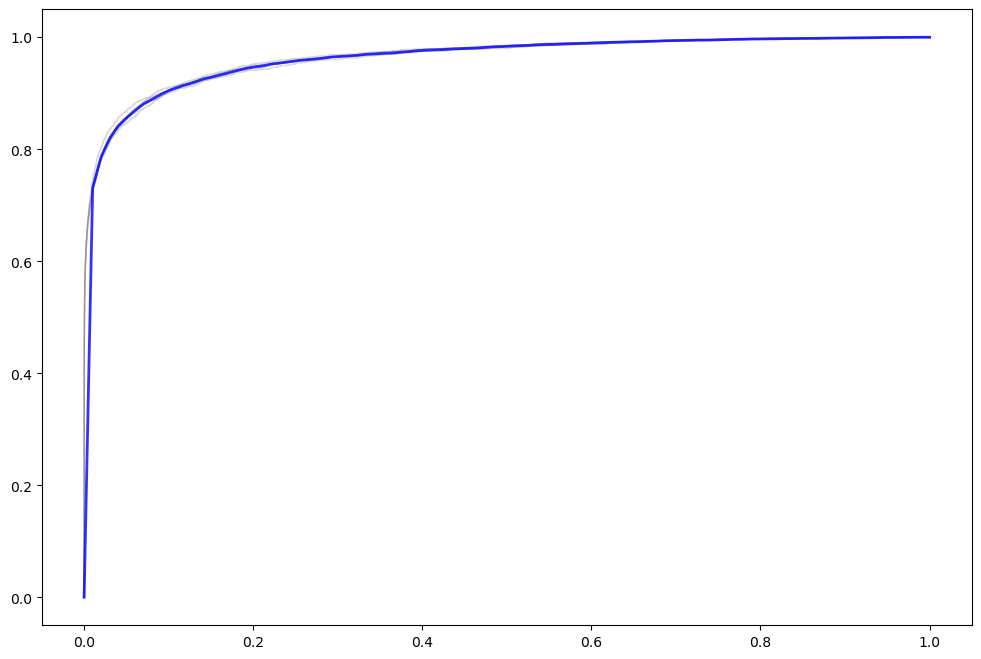

In [9]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42,
    'n_jobs': -1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(12, 8))

print("\nIniciando Cross-Validation...")
# Loop manual para controle total e plotagem
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    # Separar dobras
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Dataset LGBM
    dtrain_fold = lgb.Dataset(X_fold_train, label=y_fold_train)
    dval_fold = lgb.Dataset(X_fold_val, label=y_fold_val, reference=dtrain_fold)
    
    # Treinar
    clf = lgb.train(
        params, 
        dtrain_fold, 
        num_boost_round=1000,
        valid_sets=[dval_fold],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)] # Log 0 para não poluir
    )
    
    # Prever na dobra de validação
    y_prob_fold = clf.predict(X_fold_val, num_iteration=clf.best_iteration)
    
    # Calcular AUC da dobra
    fpr_fold, tpr_fold, _ = roc_curve(y_fold_val, y_prob_fold)
    roc_auc_fold = auc(fpr_fold, tpr_fold)
    aucs.append(roc_auc_fold)
    
    # Interpolar para gráfico médio
    interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plotar curva da dobra (cinza claro)
    plt.plot(fpr_fold, tpr_fold, lw=1, alpha=0.3, color='grey', label=f'Fold {fold+1} (AUC = {roc_auc_fold:.3f})')
    print(f"Fold {fold+1} AUC: {roc_auc_fold:.4f}")

# --- Curva Média do CV ---
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Média CV (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})', lw=2, alpha=.8)

In [10]:
dtrain_full = lgb.Dataset(X, label=y)

final_model = lgb.train(params, dtrain_full, num_boost_round=int(clf.best_iteration * 1.1))

In [12]:
y_proba_val = final_model.predict(X_holdout)

In [13]:
precisions, recalls, thresholds = precision_recall_curve(y_holdout, y_proba_val)
target_recall = 0.99 
valid_indices = np.where(recalls >= target_recall)[0]
thresh_low = thresholds[valid_indices[-1]] if len(valid_indices) > 0 else 0.0

# B) Threshold Superior (Alta Certeza): Focado em Precisão
# Vamos buscar um ponto onde a precisão sobe (ex: > 50% ou 80%), ou um corte fixo alto
# Olhando seu gráfico, 0.8 parece ser onde a curva vermelha domina totalmente
thresh_high = 0.80 

print(f"Limites Definidos:")
print(f"🟢 Verde (Baixo)   : < {thresh_low:.5f}")
print(f"🟡 Amarelo (Médio) : {thresh_low:.5f} a {thresh_high:.5f}")
print(f"🔴 Vermelho (Alto) : >= {thresh_high:.5f}")

# --- 2. APLICAÇÃO DA LÓGICA DE SEMÁFORO ---

def classificar_risco(prob):
    if prob < thresh_low:
        return '1. Verde (Baixo)'
    elif prob < thresh_high:
        return '2. Amarelo (Atenção)'
    else:
        return '3. Vermelho (Crítico)'

# Vetorizar para performance (Pandas apply é lento em milhões de linhas)
conditions = [
    (y_proba_val < thresh_low),
    (y_proba_val >= thresh_low) & (y_proba_val < thresh_high),
    (y_proba_val >= thresh_high)
]
choices = ['1. Verde', '2. Amarelo', '3. Vermelho']

# Criar DataFrame de Análise
df_risco = pd.DataFrame({
    'Real': y_holdout,
    'Probabilidade': y_proba_val,
    'Categoria': np.select(conditions, choices, default='Erro')
})

Limites Definidos:
🟢 Verde (Baixo)   : < 0.00245
🟡 Amarelo (Médio) : 0.00245 a 0.80000
🔴 Vermelho (Alto) : >= 0.80000



=== Matriz de Estratificação de Risco ===
Real         Sobreviveu  Óbito    Total  Taxa de Letalidade (%)
Categoria                                                      
1. Verde        1099897     25  1099922                0.002273
2. Amarelo       847376   1175   848551                0.138471
3. Vermelho         793   1310     2103               62.291964


/tmp/ipykernel_106184/2917280874.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Categoria', y='Probabilidade', data=df_risco, palette={'1. Verde': 'green', '2. Amarelo': 'yellow', '3. Vermelho': 'red'})


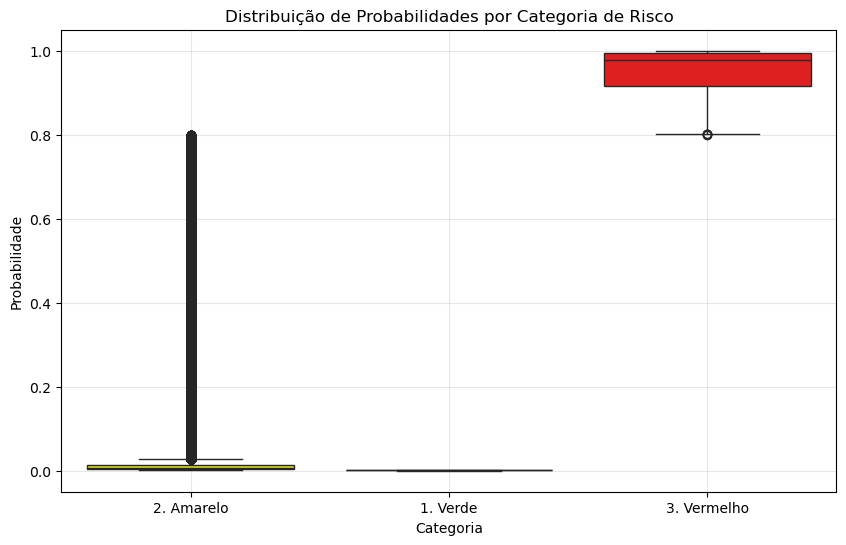


=== Resumo para Gestão ===
Total de Óbitos Reais: 2510
Óbitos na Zona Verde (Erro do Modelo): 25 (1.00% dos óbitos)
Óbitos Detectados (Amarelo + Vermelho): 2485 (99.00% dos óbitos)

Significado Prático:
- VERDE: Alta confiabilidade de alta. Pode ir para casa com orientações.
- AMARELO: Zona de incerteza. Requer exames complementares/observação (Maioria dos Falsos Positivos está aqui).
- VERMELHO: Ação imediata. Altíssima probabilidade de óbito.


In [14]:
crosstab = pd.crosstab(df_risco['Categoria'], df_risco['Real'].map({0: 'Sobreviveu', 1: 'Óbito'}))
crosstab['Total'] = crosstab.sum(axis=1)
crosstab['Taxa de Letalidade (%)'] = (crosstab['Óbito'] / crosstab['Total']) * 100

print("\n=== Matriz de Estratificação de Risco ===")
print(crosstab)

# --- 4. VISUALIZAÇÃO COM BOXPLOT ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='Categoria', y='Probabilidade', data=df_risco, palette={'1. Verde': 'green', '2. Amarelo': 'yellow', '3. Vermelho': 'red'})
plt.title('Distribuição de Probabilidades por Categoria de Risco')
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. RESUMO EXECUTIVO ---
total_obitos = crosstab['Óbito'].sum()
obitos_verde = crosstab.loc['1. Verde', 'Óbito'] if '1. Verde' in crosstab.index else 0
obitos_detectados = total_obitos - obitos_verde

print("\n=== Resumo para Gestão ===")
print(f"Total de Óbitos Reais: {total_obitos}")
print(f"Óbitos na Zona Verde (Erro do Modelo): {obitos_verde} ({(obitos_verde/total_obitos)*100:.2f}% dos óbitos)")
print(f"Óbitos Detectados (Amarelo + Vermelho): {obitos_detectados} ({(obitos_detectados/total_obitos)*100:.2f}% dos óbitos)")
print("\nSignificado Prático:")
print("- VERDE: Alta confiabilidade de alta. Pode ir para casa com orientações.")
print("- AMARELO: Zona de incerteza. Requer exames complementares/observação (Maioria dos Falsos Positivos está aqui).")
print("- VERMELHO: Ação imediata. Altíssima probabilidade de óbito.")